In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
#importing libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

In [49]:
df = pd.read_csv("/Users/steph/OneDrive/Desktop/Python/MLBRunValuesFF.csv",low_memory=False)

In [50]:
df.head(1)

,Player Name,Velocity,Pitch Count,Spin Rate,Vertical Break,Horizontal Break,Run Values,RV/100,Pitch Count/100
0,"Verlander, Justin",94.690244,11675,2543.342355,18.872449,-11.297196,-47.377098,-0.4058,116.75


In [51]:
#Drop all rows with NaN values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df = df.reset_index()

In [52]:
df.head(1)

,index,Player Name,Velocity,Pitch Count,Spin Rate,Vertical Break,Horizontal Break,Run Values,RV/100,Pitch Count/100
0,0,"Verlander, Justin",94.690244,11675,2543.342355,18.872449,-11.297196,-47.377098,-0.4058,116.75


In [53]:
#create a new dataframe with only pitches that are fastballs, sinkers and cutters
dfb = df

In [54]:
#create a column for the absolute value of the horizontal break
dfb.insert(6, "ABS Horizontal Break", abs(dfb["Horizontal Break"]), True)

In [55]:
#create a column for the differential between the vertical and horizontal break
dfb.insert(7, "Vertical - Horizontal Break", dfb["Vertical Break"] - dfb["Horizontal Break"], True)

In [56]:
#rename Vertical - Horizontal Break to differential break
dfb.rename (columns = {'Vertical - Horizontal Break':'Differential Break'}, inplace = True)

In [57]:
dfb.head(1)

,index,Player Name,Velocity,Pitch Count,Spin Rate,Vertical Break,ABS Horizontal Break,Differential Break,Horizontal Break,Run Values,RV/100,Pitch Count/100
0,0,"Verlander, Justin",94.690244,11675,2543.342355,18.872449,11.297196,30.169645,-11.297196,-47.377098,-0.4058,116.75


In [58]:
dfb = dfb[['Player Name','Velocity','Spin Rate','Vertical Break','Horizontal Break','Differential Break', 'Run Values']]


In [59]:
dfb.head(1)

,Player Name,Velocity,Spin Rate,Vertical Break,Horizontal Break,Differential Break,Run Values
0,"Verlander, Justin",94.690244,2543.342355,18.872449,-11.297196,30.169645,-47.377098


In [60]:
#Rename PLAYER NAME to PITCHER And Run Values to RV
dfb.rename (columns = {'Player Name':'PITCHER','Run Values':'RV'}, inplace = True)

C:\Users\steph\AppData\Local\Temp\ipykernel_13616\2519097936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb.rename (columns = {'Player Name':'PITCHER','Run Values':'RV'}, inplace = True)


In [61]:
X = dfb[['Velocity','Spin Rate','Vertical Break', 'Horizontal Break','Differential Break']]
y = dfb['RV'] 

In [62]:

#Split data into training and testing sets
train_test_split(X,y,test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [63]:
#Create a random forest regressor
rfr = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [64]:
#create a dataframe with the feature importances
feature_importances = pd.DataFrame(rfr.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Vertical Break,0.306941
Velocity,0.233316
Spin Rate,0.182850
Horizontal Break,0.140332
Differential Break,0.136561


In [65]:
#create a new column in dfb with the predicted run values
dfb['Predicted RV'] = rfr.predict(X)

C:\Users\steph\AppData\Local\Temp\ipykernel_13616\110280564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb['Predicted RV'] = rfr.predict(X)


In [66]:
dfb = dfb[['PITCHER','Velocity','Spin Rate','Vertical Break','Horizontal Break','Differential Break','RV', 'Predicted RV']]


In [67]:
#Create a new dataframe with averages of all the values 
dfb_avg = dfb.groupby(['PITCHER']).mean().reset_index()

In [68]:
#order the dataframe by the predicted run values lowest to highest 
dfb_avg = dfb_avg.sort_values(by=['Predicted RV'], ascending=True)

In [69]:
#check the dataframe
dfb_avg.head(5)

,PITCHER,Velocity,Spin Rate,Vertical Break,Horizontal Break,Differential Break,RV,Predicted RV
1549,"Verlander, Justin",94.690244,2543.342355,18.872449,-11.297196,30.169645,-47.377098,-24.408956
271,"Chapman, Aroldis",99.218570,2469.993536,18.272110,5.338507,12.933602,-32.806588,-16.346611
1687,"deGrom, Jacob",96.474892,2370.501345,16.250015,-6.659291,22.909307,-47.154813,-13.181952
1575,"Walden, Jordan",94.982278,2576.151899,16.227342,-13.803038,30.030380,-0.151316,-10.640993
1337,"Scherzer, Max",94.526658,2482.598107,15.072119,-11.386716,26.458835,-38.014953,-9.996513


In [70]:
#Edit The Pitcher Names so First name is first and last name is last
dfb_avg['PITCHER'] = dfb_avg['PITCHER'].str.split(' ', expand=True)[1] + ' ' + dfb_avg['PITCHER'].str.split(' ', expand=True)[0]

In [71]:
#Remove the comma from the last name
dfb_avg = dfb_avg.replace(',','', regex=True)

In [72]:
#create a new column with predicted run value times 100 called xRV/100
dfb_avg['xRV/100'] = dfb_avg['Predicted RV'] * 100

In [73]:
#reset the index
dfb_avg = dfb_avg.reset_index()

In [74]:
#drop the index column
dfb_avg = dfb_avg.drop(['index'], axis=1)

In [75]:
dfb_avg = dfb_avg[['PITCHER','Velocity','Spin Rate','Vertical Break','Horizontal Break','xRV/100']]
dfb_avg.head(5)

,PITCHER,Velocity,Spin Rate,Vertical Break,Horizontal Break,xRV/100
0,Justin Verlander,94.690244,2543.342355,18.872449,-11.297196,-2440.895586
1,Aroldis Chapman,99.218570,2469.993536,18.272110,5.338507,-1634.661107
2,Jacob deGrom,96.474892,2370.501345,16.250015,-6.659291,-1318.195181
3,Jordan Walden,94.982278,2576.151899,16.227342,-13.803038,-1064.099323
4,Max Scherzer,94.526658,2482.598107,15.072119,-11.386716,-999.651328


In [76]:
#Edit Horizontal Break to be absolute value of horizontal break
dfb_avg['Horizontal Break'] = abs(dfb_avg['Horizontal Break'])

In [77]:
dfb_avg.head(5)

,PITCHER,Velocity,Spin Rate,Vertical Break,Horizontal Break,xRV/100
0,Justin Verlander,94.690244,2543.342355,18.872449,11.297196,-2440.895586
1,Aroldis Chapman,99.218570,2469.993536,18.272110,5.338507,-1634.661107
2,Jacob deGrom,96.474892,2370.501345,16.250015,6.659291,-1318.195181
3,Jordan Walden,94.982278,2576.151899,16.227342,13.803038,-1064.099323
4,Max Scherzer,94.526658,2482.598107,15.072119,11.386716,-999.651328


In [78]:
#add in a new column called pitch count that is the number of pitches thrown by each pitcher
dfb_avg = dfb_avg.assign(Pitch_Count=dfb.groupby('PITCHER').size().values)

In [79]:
#change PITCHER to pitcher 
dfb_avg = dfb_avg.rename(columns={'PITCHER': 'Pitcher'})

In [80]:
#reorder the columns so pitch count is second
dfb_avg = dfb_avg[['Pitcher','Pitch_Count','Velocity','Spin Rate','Vertical Break','Horizontal Break','xRV/100']]

In [81]:
#change pitcher to Pitcher 
dfb_avg = dfb_avg.rename(columns={'pitcher': 'Pitcher'})

In [82]:
#find the mean of xRV/100
dfb_avg['xRV/100'].mean()

1098.4942966511417

In [83]:
dfb_avg.head(5)

,Pitcher,Pitch_Count,Velocity,Spin Rate,Vertical Break,Horizontal Break,xRV/100
0,Justin Verlander,1,94.690244,2543.342355,18.872449,11.297196,-2440.895586
1,Aroldis Chapman,1,99.218570,2469.993536,18.272110,5.338507,-1634.661107
2,Jacob deGrom,1,96.474892,2370.501345,16.250015,6.659291,-1318.195181
3,Jordan Walden,1,94.982278,2576.151899,16.227342,13.803038,-1064.099323
4,Max Scherzer,1,94.526658,2482.598107,15.072119,11.386716,-999.651328


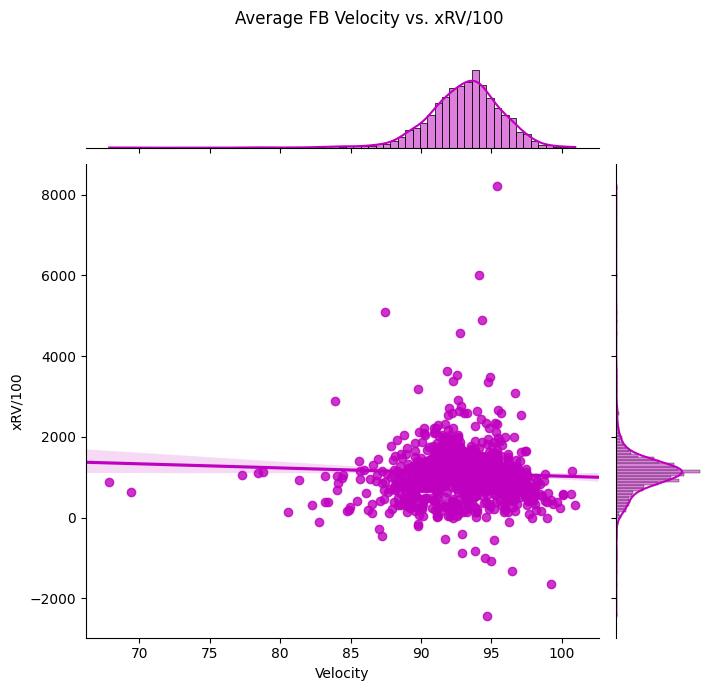

In [84]:
#create a heatmap of avaerage velocity and xRV/100
g = sns.jointplot(x="Velocity", y="xRV/100", data=dfb_avg, kind="reg", truncate=False, color="m", height=7)
g.fig.suptitle("Average FB Velocity vs. xRV/100")
g.fig.subplots_adjust(top=.9)

Text(0.5, 1.0, 'Top 10 Pitchers with Top FB xRV/100')

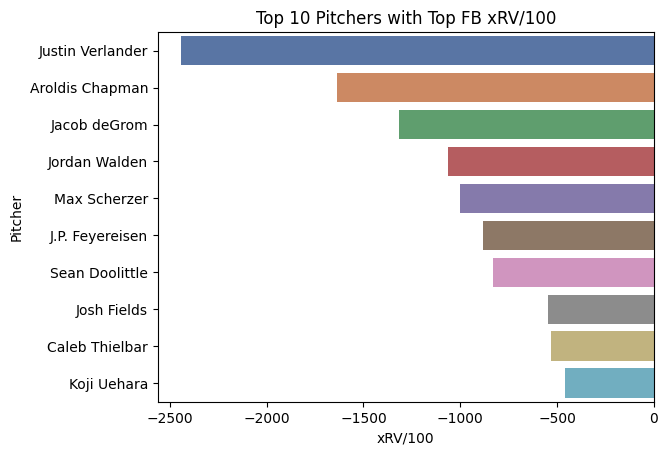

In [85]:
#create a visualation of Top 10 Pitchers with the highest xRV/100
p = sns.barplot(x="xRV/100", y="Pitcher", data=dfb_avg.head(10), palette= 'deep')
#p.set(xlabel='xRV/100', ylabel='Pitcher')
p.set_title('Top 10 Pitchers with Top FB xRV/100')

In [86]:
dfb_avg['xRV/100'].describe()

count    1689.000000
mean     1098.494297
std       545.707740
min     -2440.895586
25%       869.042804
50%      1108.145606
75%      1321.239504
max      8227.283090
Name: xRV/100, dtype: float64

In [87]:
#Create a new column called xRV/100 scaled negative which is the xRV/100 - 3.503456
dfb_avg = dfb_avg.assign(xRV100_scaled_negative=dfb_avg['xRV/100'] - 3.50345)

In [88]:
dfb_avg['xRV100_scaled_negative'].describe()

count    1689.000000
mean     1094.990847
std       545.707740
min     -2444.399036
25%       865.539354
50%      1104.642156
75%      1317.736054
max      8223.779640
Name: xRV100_scaled_negative, dtype: float64

In [89]:
#Create a new column which is the aboslute value of xRV/100 scaled negative
dfb_avg = dfb_avg.assign(xRV100_scaled_negative_abs=dfb_avg['xRV100_scaled_negative'].abs())

In [90]:
#create a new column called Stuff+ which is ((xRV100_scaled_negative_abs)/mean of xRV100_scaled_negative_abs) * 100
dfb_avg = dfb_avg.assign(Stuff_plus=(dfb_avg['xRV100_scaled_negative_abs']/dfb_avg['xRV100_scaled_negative_abs'].mean())*100)
dfb_avg.head(5)

,Pitcher,Pitch_Count,Velocity,Spin Rate,Vertical Break,Horizontal Break,xRV/100,xRV100_scaled_negative,xRV100_scaled_negative_abs,Stuff_plus
0,Justin Verlander,1,94.690244,2543.342355,18.872449,11.297196,-2440.895586,-2444.399036,2444.399036,220.358388
1,Aroldis Chapman,1,99.218570,2469.993536,18.272110,5.338507,-1634.661107,-1638.164557,1638.164557,147.677730
2,Jacob deGrom,1,96.474892,2370.501345,16.250015,6.659291,-1318.195181,-1321.698631,1321.698631,119.148869
3,Jordan Walden,1,94.982278,2576.151899,16.227342,13.803038,-1064.099323,-1067.602773,1067.602773,96.242562
4,Max Scherzer,1,94.526658,2482.598107,15.072119,11.386716,-999.651328,-1003.154778,1003.154778,90.432686


In [91]:
#make all the numbers in dataframe rounded to 2 decimal places
dfb_avg = dfb_avg.round(2)

In [92]:
dfb_avg.head(25)

,Pitcher,Pitch_Count,Velocity,Spin Rate,Vertical Break,Horizontal Break,xRV/100,xRV100_scaled_negative,xRV100_scaled_negative_abs,Stuff_plus
0,Justin Verlander,1,94.69,2543.34,18.87,11.30,-2440.90,-2444.40,2444.40,220.36
1,Aroldis Chapman,1,99.22,2469.99,18.27,5.34,-1634.66,-1638.16,1638.16,147.68
2,Jacob deGrom,1,96.47,2370.50,16.25,6.66,-1318.20,-1321.70,1321.70,119.15
3,Jordan Walden,1,94.98,2576.15,16.23,13.80,-1064.10,-1067.60,1067.60,96.24
4,Max Scherzer,1,94.53,2482.60,15.07,11.39,-999.65,-1003.15,1003.15,90.43
5,J.P. Feyereisen,1,92.94,2470.90,20.64,5.04,-884.75,-888.25,888.25,80.07
6,Sean Doolittle,1,93.85,2232.21,19.97,4.57,-832.61,-836.12,836.12,75.37
7,Josh Fields,1,95.18,2250.37,20.15,2.49,-546.56,-550.06,550.06,49.59
8,Caleb Thielbar,1,91.72,2317.12,19.38,2.85,-528.62,-532.12,532.12,47.97
9,Koji Uehara,1,87.23,2384.59,20.46,11.22,-458.98,-462.48,462.48,41.69


In [93]:
print('Yamamoto Yoshinobu' in dfb_avg['Pitcher'].unique())

True


In [95]:
dfb_avg.to_csv('dfb_avg.csv')